In [1]:
import pandas as pd
import numpy as np
# from dotenv import load_dotenv
from pandas.tseries.offsets import DateOffset
import os
import requests
import datetime
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.requests import CryptoLatestQuoteRequest
from alpaca.data.requests import CryptoTradesRequest
from alpaca.data.timeframe import TimeFrame
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
import matplotlib.pyplot as plt
from numpy.lib import math

%matplotlib inline

## Data Retreival/Formatting

In [2]:
# alpaca_api_key = os.getenv("ALPACA_API_KEY")
# alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

In [3]:
# type(alpaca_api_key)

In [4]:
crypto_client = CryptoHistoricalDataClient()

In [5]:
request_params = CryptoBarsRequest(
    symbol_or_symbols=["ETH/USD"],
    timeframe=TimeFrame.Hour, start='2021-09-30 00:00:00'
)

eth_bars = crypto_client.get_crypto_bars(request_params)

eth_df = eth_bars.df

eth_df

open    high     low   close    volume  \
symbol  timestamp                                                             
ETH/USD 2021-09-30 00:00:00+00:00  2849.8  2934.8  2838.3  2934.2   706.304   
        2021-09-30 01:00:00+00:00  2935.8  2985.4  2918.2  2961.0   760.251   
        2021-09-30 02:00:00+00:00  2965.4  2994.4  2961.1  2990.6  3886.627   
        2021-09-30 03:00:00+00:00  2992.0  3035.8  2970.0  3029.0  5551.980   
        2021-09-30 04:00:00+00:00  3030.3  3049.2  3014.0  3017.1   401.627   
...                                   ...     ...     ...     ...       ...   
        2022-10-03 21:00:00+00:00  1323.9  1324.0  1317.8  1318.3   636.042   
        2022-10-03 22:00:00+00:00  1318.3  1321.7  1315.4  1315.7  1063.529   
        2022-10-03 23:00:00+00:00  1315.7  1328.0  1315.7  1323.9  1721.348   
        2022-10-04 00:00:00+00:00  1323.7  1330.0  1320.8  1321.8   884.097   
        2022-10-04 01:00:00+00:00  1321.9  1323.1  1321.7  1323.1    84.916   

                                   trade_count         vwap  
symbol  timestamp                                            
ETH/USD 2021-09-30 00:00:00+00:00        393.0  2887.453790  
        2021-09-30 01:00:00+00:00        352.0  2957.585712  
        2021-09-30 02:00:00+00:00        573.0  2975.692584  
        2021-09-30 03:00:00+00:00        669.0  2991.111283  
        2021-09-30 04:00:00+00:00        115.0  3030.674760  
...                                        ...          ...  
        2022-10-03 21:00:00+00:00        783.0  1320.154127  
        2022-10-03 22:00:00+00:00        911.0  1317.203945  
        2022-10-03 23:00:00+00:00       1207.0  1322.397561  
        2022-10-04 00:00:00+00:00        848.0  1325.526781  
        2022-10-04 01:00:00+00:00         60.0  1322.279689  

[8840 rows x 7 columns]

In [6]:
eth_df.dtypes

open           float64
high           float64
low            float64
close          float64
volume         float64
trade_count    float64
vwap           float64
dtype: object

In [7]:
eth_df = eth_df.reset_index()
eth_df = eth_df.set_index('timestamp')
eth_df = eth_df.drop(columns=['symbol'])

eth_df

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2021-09-30 00:00:00+00:00,2849.8,2934.8,2838.3,2934.2,706.304,393.0,2887.453790
2021-09-30 01:00:00+00:00,2935.8,2985.4,2918.2,2961.0,760.251,352.0,2957.585712
2021-09-30 02:00:00+00:00,2965.4,2994.4,2961.1,2990.6,3886.627,573.0,2975.692584
2021-09-30 03:00:00+00:00,2992.0,3035.8,2970.0,3029.0,5551.980,669.0,2991.111283
2021-09-30 04:00:00+00:00,3030.3,3049.2,3014.0,3017.1,401.627,115.0,3030.674760
...,...,...,...,...,...,...,...
2022-10-03 21:00:00+00:00,1323.9,1324.0,1317.8,1318.3,636.042,783.0,1320.154127
2022-10-03 22:00:00+00:00,1318.3,1321.7,1315.4,1315.7,1063.529,911.0,1317.203945
2022-10-03 23:00:00+00:00,1315.7,1328.0,1315.7,1323.9,1721.348,1207.0,1322.397561


In [8]:
# Use the pct_change function to generate  returns from close prices
eth_df["Actual Returns"] = eth_df["close"].pct_change()

# Drop na
eth_df=eth_df.dropna()

In [9]:
# Initialize the new Signal column
eth_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
eth_df.loc[(eth_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
eth_df.loc[(eth_df['Actual Returns'] < 0), 'Signal'] = 0

eth_df

C:\Users\deerr\anaconda3\envs\dev\envs\dev\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\deerr\anaconda3\envs\dev\envs\dev\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,open,high,low,close,volume,trade_count,vwap,Actual Returns,Signal
timestamp,,,,,,,,,
2021-09-30 01:00:00+00:00,2935.8,2985.4,2918.2,2961.0,760.251,352.0,2957.585712,0.009134,1.0
2021-09-30 02:00:00+00:00,2965.4,2994.4,2961.1,2990.6,3886.627,573.0,2975.692584,0.009997,1.0
2021-09-30 03:00:00+00:00,2992.0,3035.8,2970.0,3029.0,5551.980,669.0,2991.111283,0.012840,1.0
2021-09-30 04:00:00+00:00,3030.3,3049.2,3014.0,3017.1,401.627,115.0,3030.674760,-0.003929,0.0
2021-09-30 05:00:00+00:00,3023.0,3041.3,3019.5,3029.7,141.883,108.0,3025.002656,0.004176,1.0
...,...,...,...,...,...,...,...,...,...
2022-10-03 21:00:00+00:00,1323.9,1324.0,1317.8,1318.3,636.042,783.0,1320.154127,-0.004230,0.0
2022-10-03 22:00:00+00:00,1318.3,1321.7,1315.4,1315.7,1063.529,911.0,1317.203945,-0.001972,0.0
2022-10-03 23:00:00+00:00,1315.7,1328.0,1315.7,1323.9,1721.348,1207.0,1322.397561,0.006232,1.0


In [10]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = eth_df[['open', 'high','low','close','volume', 'trade_count']].shift().dropna()

# Review the DataFrame
X.head()

,open,high,low,close,volume,trade_count
timestamp,,,,,,
2021-09-30 02:00:00+00:00,2935.8,2985.4,2918.2,2961.0,760.251,352.0
2021-09-30 03:00:00+00:00,2965.4,2994.4,2961.1,2990.6,3886.627,573.0
2021-09-30 04:00:00+00:00,2992.0,3035.8,2970.0,3029.0,5551.980,669.0
2021-09-30 05:00:00+00:00,3030.3,3049.2,3014.0,3017.1,401.627,115.0
2021-09-30 06:00:00+00:00,3023.0,3041.3,3019.5,3029.7,141.883,108.0


In [11]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the scaler to the features training dataset
X_scaled = scaler.fit_transform(X)

X_scaled

array([[ 0.23578222,  0.2669793 ,  0.23557605,  0.25965119, -0.27470499,
        -0.34849172],
       [ 0.26352417,  0.2753841 ,  0.27595607,  0.28739225,  0.88123078,
        -0.03379686],
       [ 0.28845444,  0.31404614,  0.28433327,  0.32338065,  1.49697282,
         0.10290316],
       ...,
       [-1.28018434, -1.28669308, -1.27307396, -1.28232053, -0.162572  ,
         0.44750115],
       [-1.28262113, -1.28080972, -1.27279158, -1.27463551,  0.08064779,
         0.86899289],
       [-1.27512331, -1.27894199, -1.26799116, -1.27660362, -0.22891459,
         0.35779175]])

In [12]:
# get array representation of dataframe
dataset = eth_df.values

# get number of rows to train the model on
training_data_len = math.ceil(len(dataset) * 0.8)

training_data_len

7072

In [15]:
# create train dataset
train_data = X_scaled[0:training_data_len, :]

# Create blank array
X_train = []
candles = 60

for i in range(candles, len(train_data)):
    X_train.append(train_data[i-candles:i, 0:6])

# display(X_train.head())

# create test dataset
test_data = X_scaled[training_data_len - candles: , :]

# Create blank array
X_test = []

for i in range(candles, len(test_data)):
    X_test.append(test_data[i-candles:i, 0:6])


In [16]:
# Convert lists to array

X_train = np.array(X_train)
X_test = np.array(X_test)

display(len(X_train))
display(len(X_test))
display(X_train)

7012

1766

array([[[ 0.23578222,  0.2669793 ,  0.23557605,  0.25965119,
         -0.27470499, -0.34849172],
        [ 0.26352417,  0.2753841 ,  0.27595607,  0.28739225,
          0.88123078, -0.03379686],
        [ 0.28845444,  0.31404614,  0.28433327,  0.32338065,
          1.49697282,  0.10290316],
        ...,
        [ 0.56371835,  0.55666445,  0.57508819,  0.55758641,
         -0.5330411 , -0.79703868],
        [ 0.55837615,  0.55825202,  0.57113491,  0.57305017,
         -0.50815967, -0.76571159],
        [ 0.57805794,  0.56796422,  0.58798344,  0.58204727,
         -0.49785252, -0.77283138]],

       [[ 0.26352417,  0.2753841 ,  0.27595607,  0.28739225,
          0.88123078, -0.03379686],
        [ 0.28845444,  0.31404614,  0.28433327,  0.32338065,
          1.49697282,  0.10290316],
        [ 0.32435028,  0.32655994,  0.32574867,  0.31222799,
         -0.40730143, -0.6859699 ],
        ...,
        [ 0.55837615,  0.55825202,  0.57113491,  0.57305017,
         -0.50815967, -0.76571159],
  

In [17]:
# Create the target set selecting the Signal column and assiging it to y
y = eth_df['Signal']

# Review the value counts
display(y)

# Drop first row
y = y.iloc[1:-60]

display(y)

timestamp
2021-09-30 01:00:00+00:00    1.0
2021-09-30 02:00:00+00:00    1.0
2021-09-30 03:00:00+00:00    1.0
2021-09-30 04:00:00+00:00    0.0
2021-09-30 05:00:00+00:00    1.0
                            ... 
2022-10-03 21:00:00+00:00    0.0
2022-10-03 22:00:00+00:00    0.0
2022-10-03 23:00:00+00:00    1.0
2022-10-04 00:00:00+00:00    0.0
2022-10-04 01:00:00+00:00    1.0
Name: Signal, Length: 8839, dtype: float64

timestamp
2021-09-30 02:00:00+00:00    1.0
2021-09-30 03:00:00+00:00    1.0
2021-09-30 04:00:00+00:00    0.0
2021-09-30 05:00:00+00:00    1.0
2021-09-30 06:00:00+00:00    0.0
                            ... 
2022-10-01 09:00:00+00:00    0.0
2022-10-01 10:00:00+00:00    0.0
2022-10-01 11:00:00+00:00    0.0
2022-10-01 12:00:00+00:00    0.0
2022-10-01 13:00:00+00:00    1.0
Name: Signal, Length: 8778, dtype: float64

In [18]:
# Splitting Y data

y_train = y.iloc[0:len(X_train)]
y_test = y.iloc[len(X_train):]

display(y_train.count())
display(y_test.count())

7012

1766

## Model Creation

In [19]:
# Define the the number of inputs (features) to the model
number_input_features = len(X.columns)

# Review the number of features
number_input_features


6

In [20]:
# Create the Sequential model instance
nn = Sequential()

# Define the number of neurons in the output layer
number_output_neurons = 1

# Define the number of hidden nodes for the first hidden layer
# hidden_nodes_layer1 = (number_input_features + 1) // 2
hidden_nodes_layer1 = 64

# Review the number hidden nodes in the first layer
display(hidden_nodes_layer1)

# Define the number of hidden nodes for the second hidden layer
# hidden_nodes_layer2 = (hidden_nodes_layer1 + 1) //2
hidden_nodes_layer2 = 64

# Review the number hidden nodes in the second layer
display(hidden_nodes_layer2)

64

64

In [21]:
# Add the first hidden layer
nn.add(LSTM(units=hidden_nodes_layer1, return_sequences=True, input_dim=number_input_features))

In [22]:
#Add the second hidden layer
nn.add(LSTM(units=hidden_nodes_layer2))


In [23]:
# Add the output layer to the model specifying the number of output neurons and activation function
nn.add(Dense(units=1,  activation='sigmoid'))


In [24]:
# Display the Sequential model summary
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 64)          18176     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 51,265
Trainable params: 51,265
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Compile the Sequential model
# nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=('accuracy','Precision', 'Recall'))

nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=('accuracy'))

In [26]:
# Fit the model using 50 epochs and the training data
model_01 = nn.fit(X_train, y_train, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
198/198 [==============================] - 12s 36ms/step - loss: 0.6948 - accuracy: 0.4998 - val_loss: 0.6958 - val_accuracy: 0.4972
Epoch 2/30
198/198 [==============================] - 7s 35ms/step - loss: 0.6935 - accuracy: 0.5113 - val_loss: 0.6982 - val_accuracy: 0.4972
Epoch 3/30
198/198 [==============================] - 6s 32ms/step - loss: 0.6931 - accuracy: 0.5097 - val_loss: 0.6973 - val_accuracy: 0.4972
Epoch 4/30
198/198 [==============================] - 7s 34ms/step - loss: 0.6928 - accuracy: 0.5049 - val_loss: 0.7049 - val_accuracy: 0.4972
Epoch 5/30
198/198 [==============================] - 7s 36ms/step - loss: 0.6929 - accuracy: 0.5041 - val_loss: 0.7037 - val_accuracy: 0.4972
Epoch 6/30
198/198 [==============================] - 7s 34ms/step - loss: 0.6931 - accuracy: 0.5084 - val_loss: 0.6998 - val_accuracy: 0.4972
Epoch 7/30
198/198 [==============================] - 7s 34ms/step - loss: 0.6927 - accuracy: 0.5067 - val_loss: 0.6992 - val_accuracy: 0.497

In [27]:
# Evaluate the model loss and accuracy metrics using the evaluate method and the test data
# model_loss, model_accuracy, model_precision, model_recall = nn.evaluate(X_test, y_test)

model_loss, model_accuracy = nn.evaluate(X_test, y_test)

# Display the model loss and accuracy results
# print(f"Loss: {model_loss}, Accuracy: {model_accuracy}, Precision: {model_precision}, Recall: {model_recall}")

print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

56/56 [==============================] - 1s 12ms/step - loss: 0.7048 - accuracy: 0.5119
Loss: 0.7048144340515137, Accuracy: 0.5118913054466248


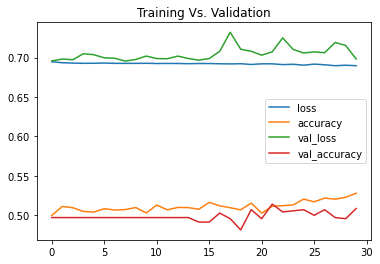

In [28]:
# Train vs test for loss
plt.plot(model_01.history["loss"])
plt.plot(model_01.history["accuracy"])
plt.plot(model_01.history["val_loss"])
plt.plot(model_01.history["val_accuracy"])
plt.title("Training Vs. Validation")
plt.legend(["loss", "accuracy","val_loss","val_accuracy"])
plt.show()